In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from opxrd.wrapper import OpXRD

test_dirpath = '/media/daniel/mirrors/xrd.aimat.science/local/final/CNRS'
full_dirpath = '/home/daniel/OneDrive/Downloads/opxrd_in_situ/LBNL'
database = OpXRD.load(dirpath=test_dirpath)

2025-04-24 12:02:31,341 - INFO - Loading patterns from local dirpath /media/daniel/mirrors/xrd.aimat.science/local/final/CNRS
100% (1058 of 1058) |####################| Elapsed Time: 0:00:05 Time:  0:00:050000
2025-04-24 12:02:36,835 - INFO - Finished loading pattern database located at /media/daniel/mirrors/xrd.aimat.science/local/final/CNRS
2025-04-24 12:02:36,835 - INFO - Successfully extracted 1058 patterns from 1058/1058 xrd files


In [3]:
from opxrd.analysis import PlotAnalysis

analyser = PlotAnalysis(databases=[database], output_dirpath='/tmp/opxrd_analysis')

---> Combined pattern plot for databaes ['a:CNRS'] | No. patterns = 50

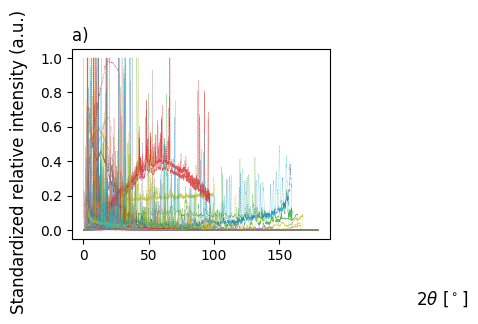

In [4]:
analyser.plot_in_single(limit_patterns=50)

---> Cumulative explained variance ratio $v$ over components |  $v =  \frac{\sum_i \lambda_i}{\sum^n_{j=1} \lambda_j}$

/home/daniel/aimat/opxrd/opxrd/analysis/plot.py:162: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right', ncols=2, fontsize='small')


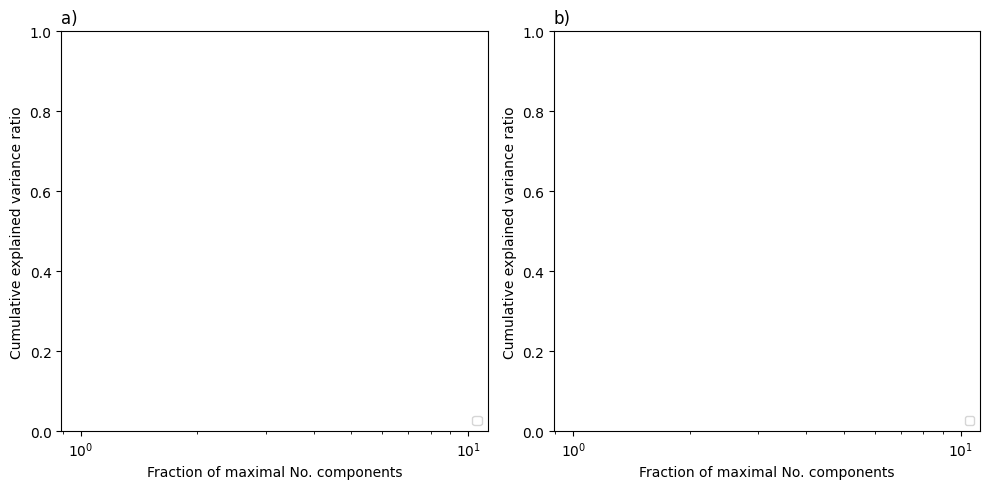

---> Cumulative explained variance ratio $v$ over components |  $v =  \frac{\sum_i \lambda_i}{\sum^n_{j=1} \lambda_j}$

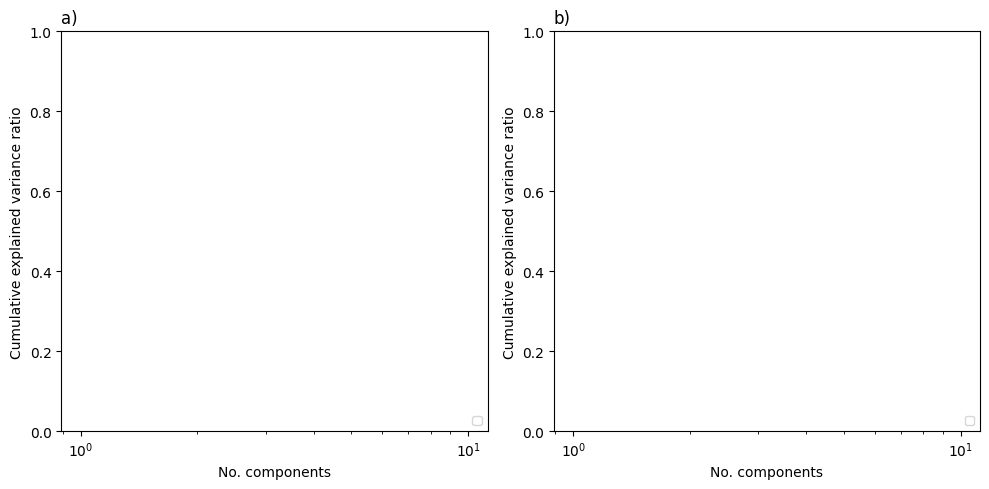

In [5]:
analyser.plot_effective_components()
analyser.plot_effective_components(use_fractions=False)

---> Histograms detailing properties of patterns in the opXRD database: a) distribution of angular resolu-tion in all data; b) distribution of smallest and largest recorded 2θ values for all data.

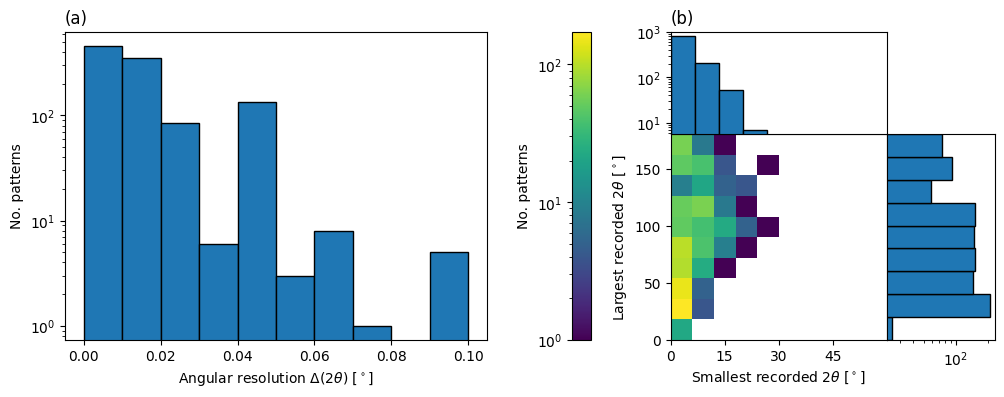

In [6]:
analyser.xrd_histogram()

/home/daniel/aimat/opxrd/opxrd/analysis/visualization.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(spg_formulas, rotation=90)


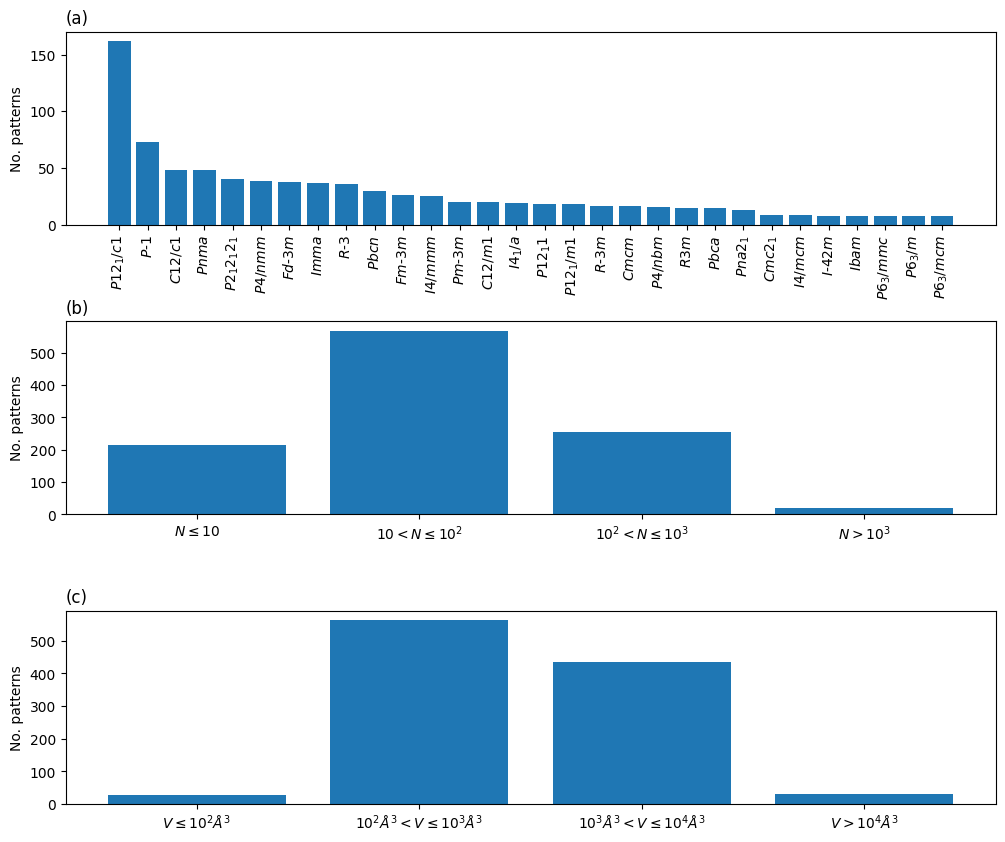

In [26]:
analyser.structure_histogram()